#### [1] Preparation

In [1]:
# --- imports
# Models
from sklearn.decomposition import PCA
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, CompoundKernel, WhiteKernel
# Data handling
import numpy as np
import pandas as pd
# plotting
import matplotlib
matplotlib.rc('font', family='Palatino Linotype')
from matplotlib import pyplot as plt

#### [2] Data Preparation

In [2]:
# --- load data
input_data = []
for i in range(1,8):
    input_data.append(np.load(f"../samples/SampleXS_{i}.npy"))
input_data = np.array(input_data)
output_data = np.load(f"../samples/SampleOutput.npy")

In [ ]:
# --- Data information and visualization
print("(Samples) x (ij) x (k))")
print(f"Inputs Shape:\t{[i.shape for i in input_data]}\t or {input_data.shape}") # type:ignore
print(f"Outputs Shape:\t{[output_data.shape]}")

(Samples) x (ij) x (k))
Inputs Shape:	[(500, 81, 16), (500, 81, 16), (500, 81, 16), (500, 81, 16), (500, 81, 16), (500, 81, 16), (500, 81, 16)]	 or (7, 500, 81, 16)
Outputs Shape:	[(500, 81, 16)]


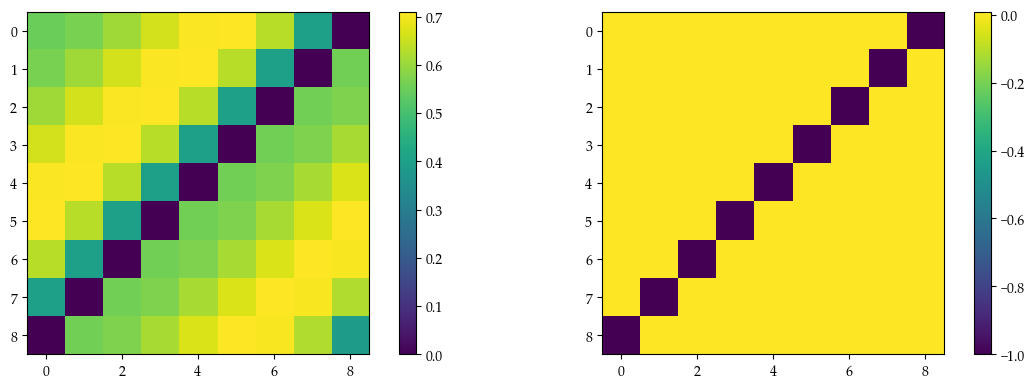

In [4]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

ax = axs[0]
image = ax.imshow([output_data[10,i:i+9,0] for i in range(0,9)])
fig.colorbar(image)

ax = axs[1]
image = ax.imshow([input_data[2][10,i:i+9,0] for i in range(0,9)])
fig.colorbar(image)

fig.tight_layout()

In [18]:
# --- Data flattening and reformatting
flattened_outputs = output_data.reshape((500,81*16))
print(flattened_outputs.shape)

print((flattened_outputs.reshape(500,81,16) == output_data).all())

(500, 1296)
True


In [19]:
print(f"Pre:\t{input_data.shape}") #type:ignore
flattened_inputs = input_data.reshape(500, 81*16*7) #type:ignore
print(f"Post:\t{flattened_inputs.shape}") #type:ignore

print((flattened_inputs.reshape(7,500,81,16) == input_data).all())

Pre:	(7, 500, 81, 16)
Post:	(500, 9072)
True


#### [3] Forward PCA

Text(0.5, 0, 'Number of Principle Components')

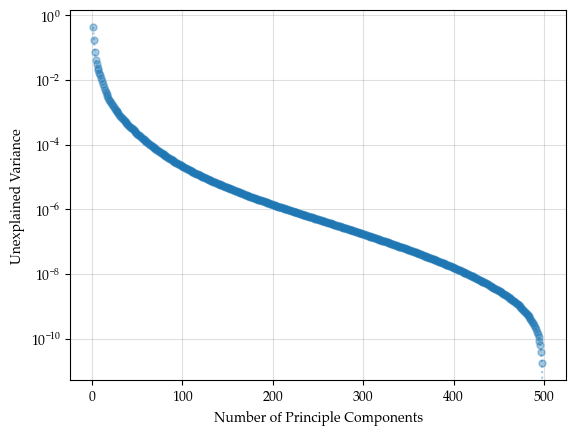

In [7]:
# --- Peform PCA
pcs = [i for i in range(1,501)]

PCA_ALL = PCA(n_components=500, copy=True)
power_pca = PCA_ALL.fit(flattened_outputs)
cumulative_variance = [1-np.sum(power_pca.explained_variance_ratio_[:i]) for i in range(1,501)]

fig,ax = plt.subplots(1,1)
ax.plot(pcs, cumulative_variance, marker='o', markersize=5, ls=':', color='tab:blue', alpha=0.4)
ax.set_yscale('log'); ax.grid(visible=True, which='both', color='gray', alpha=0.25)
ax.set_ylabel("Unexplained Variance"); ax.set_xlabel("Number of Principle Components")

Text(0.5, 0, 'Number of Principle Components')

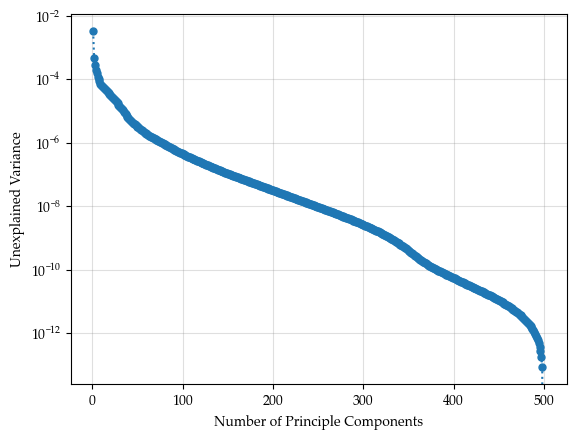

In [8]:
# --- Peform PCA on inputs
pcs = [i for i in range(1,501)]

PCA_ALL = PCA(n_components=500, copy=True)
xs_pca = PCA_ALL.fit(flattened_inputs)
cumulative_xs_variance = [1-np.sum(xs_pca.explained_variance_ratio_[:i]) for i in range(1,501)]

fig,ax = plt.subplots(1,1)
ax.plot(pcs, cumulative_xs_variance, marker='o', markersize=5, ls=':', color='tab:blue')
ax.set_yscale('log'); ax.grid(visible=True, which='both', color='gray', alpha=0.25)
ax.set_ylabel("Unexplained Variance"); ax.set_xlabel("Number of Principle Components")

In [11]:
INP_0999 = PCA(n_components=0.99999, copy=True)
input_0999 = INP_0999.fit(flattened_inputs)
input_scores = input_0999.transform(flattened_inputs)
print(input_scores.shape)

(500, 35)


In [27]:
PCA_0999 = PCA(n_components=0.999, copy=True)
power_0999 = PCA_0999.fit(flattened_outputs)
pca_scores = power_0999.transform(flattened_outputs)
print(pca_scores.shape)

(500, 29)


#### [4] Backward PCA

In [28]:
# --- Invert PCA
recovered_data = power_0999.inverse_transform(pca_scores).reshape(500,81,16)


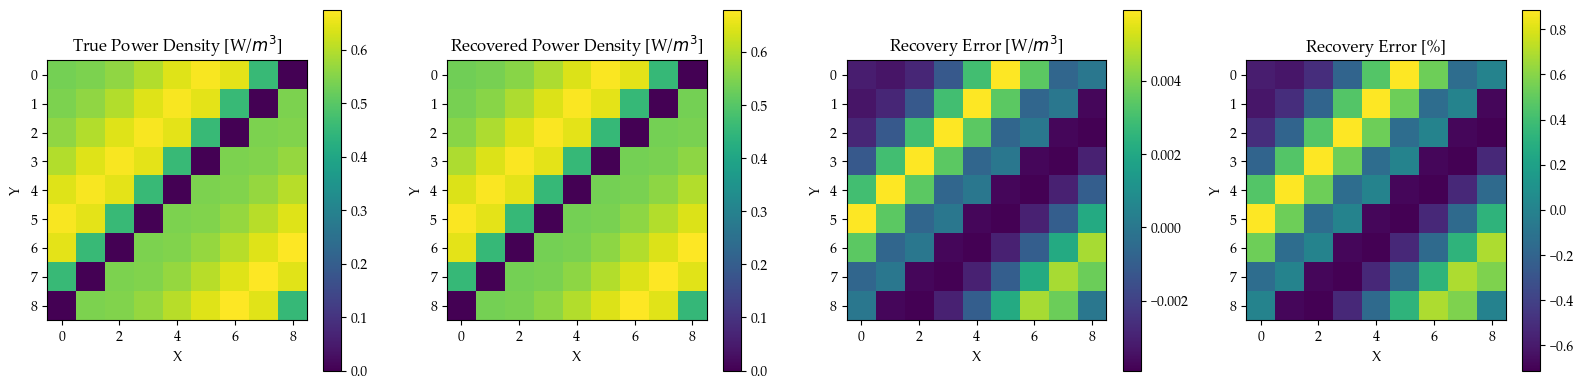

In [52]:
fig, axs = plt.subplots(1,4, figsize=(16,4))

ijk = 42

ax = axs[0]
image = ax.imshow([output_data[ijk,i:i+9,0] for i in range(0,9)])
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("True Power Density [W/$m^3$]")

ax = axs[1]
image = ax.imshow([recovered_data[ijk,i:i+9,0] for i in range(0,9)])
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("Recovered Power Density [W/$m^3$]")

ax = axs[2]
diff = np.subtract([recovered_data[ijk,i:i+9,0] for i in range(0,9)], [output_data[ijk,i:i+9,0] for i in range(0,9)])
image = ax.imshow(diff)
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("Recovery Error [W/$m^3$]")

ax = axs[3]
rel_diff = np.divide(diff, np.array([output_data[ijk,i:i+9,0] for i in range(0,9)])+1e-8)*100# - np.flip(np.identity(9), 0)*100
image = ax.imshow(rel_diff)
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("Recovery Error [%]")

fig.tight_layout()

In [13]:
recovered_inputs = input_0999.inverse_transform(input_scores).reshape(7,500,81,16)

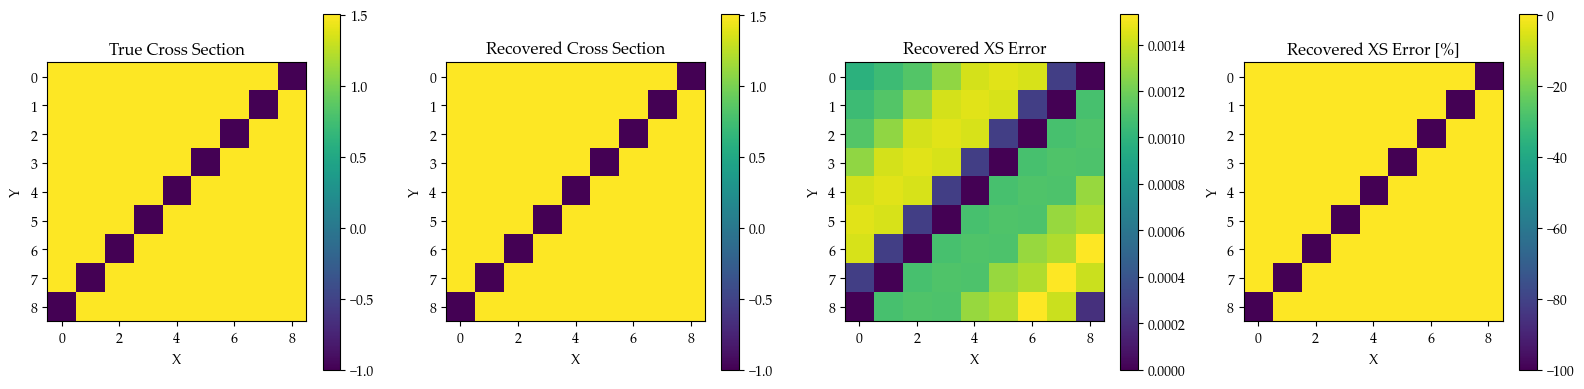

In [24]:
fig, axs = plt.subplots(1,4, figsize=(16,4))

z = 0
d = 0
ijk = 42

ax = axs[0]
image = ax.imshow([input_data[d,ijk,i:i+9,z] for i in range(0,9)]) #type:ignore
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("True Cross Section")

ax = axs[1]
image = ax.imshow([recovered_inputs[d,ijk,i:i+9,z] for i in range(0,9)])
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("Recovered Cross Section")

ax = axs[2]
diff = np.subtract([recovered_inputs[d,ijk,i:i+9,z] for i in range(0,9)], [input_data[d,ijk,i:i+9,z] for i in range(0,9)]) #type:ignore
image = ax.imshow(diff)
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("Recovered XS Error")

ax = axs[3]
rel_diff = np.divide(diff, [input_data[d,ijk,i:i+9,z] for i in range(0,9)])*100 - np.flip(np.identity(9), 0)*100 #type:ignore
image = ax.imshow(rel_diff)
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("Recovered XS Error [%]")

fig.tight_layout()

#### [5] PCA Error Analysis

In [46]:
# --- Examine Error in values caused by PCA of outputs
def o(val, precision=5):
    return np.round(val, precision)

def MaximumAbsoluteError(output, target, relative = False):
    if relative:
        return np.max(np.abs(np.divide(np.subtract(output, target), target+1e-8)))
    else:
        return np.max(np.abs(np.subtract(output, target)))

def MeanAbsoluteError(output, target, relative = False):
    if relative:
        return np.mean(np.abs(np.divide(np.subtract(output, target), target+1e-8)))
    else:
        return np.mean(np.abs(np.subtract(output, target)))

def MeanSquareError(output, target, relative = False):
    if relative:
        return np.mean(np.square(np.divide(np.subtract(output, target), target+1e-8)))
    else:
        return np.mean(np.square(np.subtract(output, target)))

def RootMeanSquareError(output, target, relative = False):
    if relative:
        return np.sqrt(MeanSquareError(output, target, relative=True))
    else:
        return np.sqrt(MeanSquareError(output, target))

def CoefficientOfDetermination(output, target, relative = False):
    mean = np.mean(target)
    ssres = np.sum(np.square(np.subtract(target, output)))
    sstot = np.sum(np.square(np.subtract(target, mean)))
    return 1 - ssres/sstot

In [49]:
# --- Output Errors
print("Output PCA Errors")
print("___________________________________________________")
print(f"MaxAE:\t{o(MaximumAbsoluteError(recovered_data, output_data))}\t({o(MaximumAbsoluteError(recovered_data, output_data, relative=True))*100} %)")
print(f"MAE:\t{o(MeanAbsoluteError(recovered_data, output_data))}\t({o(MeanAbsoluteError(recovered_data, output_data, relative=True))*100} %)")
print(f"MSE:\t{o(MeanSquareError(recovered_data, output_data))}\t({o(MeanSquareError(recovered_data, output_data, relative=True))*100} %)")
print(f"RMSE:\t{o(RootMeanSquareError(recovered_data, output_data))}\t({o(RootMeanSquareError(recovered_data, output_data, relative=True))*100} %)")

print(f"R2:\t{CoefficientOfDetermination(recovered_data, output_data)}")

Output PCA Errors
___________________________________________________
MaxAE:	0.15262	(27.125 %)
MAE:	0.00549	(0.66 %)
MSE:	9e-05	(0.013999999999999999 %)
RMSE:	0.00937	(1.175 %)
R2:	0.9997687247953452


In [50]:
# --- Output Errors
print("Input PCA Errors")
print("___________________________________________________")
print(f"MaxAE:\t{o(MaximumAbsoluteError(recovered_inputs, input_data))}\t({o(MaximumAbsoluteError(recovered_inputs, input_data, relative=True))*100} %)")
print(f"MAE:\t{o(MeanAbsoluteError(recovered_inputs, input_data))}\t({o(MeanAbsoluteError(recovered_inputs, input_data, relative=True))*100} %)")
print(f"MSE:\t{o(MeanSquareError(recovered_inputs, input_data))}\t({o(MeanSquareError(recovered_inputs, input_data, relative=True))*100} %)")
print(f"RMSE:\t{o(RootMeanSquareError(recovered_inputs, input_data))}\t({o(RootMeanSquareError(recovered_inputs, input_data, relative=True))*100} %)")

print(f"R2:\t{CoefficientOfDetermination(recovered_inputs, input_data)}")

Input PCA Errors
___________________________________________________
MaxAE:	0.01537	(82.185 %)
MAE:	0.00062	(0.5519999999999999 %)
MSE:	0.0	(0.015 %)
RMSE:	0.00124	(1.2349999999999999 %)
R2:	0.9999967386739541
